# A simple dynamic Malthusian model

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [81]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

\begin{align}
    Y_t &= L_t^{1-\alpha}\,(AX)^\alpha \, , \;\; 0<\alpha<1 \label{eq0}\tag{0} \\
    y_t &= (AX/L_t)^\alpha \label{eq1}\tag{1} \\
    n_t &= \eta y_t \label{eq2}\tag{2} \\
    L_{t+1} &= n_t L_t + (1-\mu) L_t \label{eq3}\tag{3} \\
\end{align}

See ([1](#mjx-eqn-eq1)) and ([2](#mjx-eqn-eq2))

In [459]:
y_t = sm.symbols('y_t', real=True, nonnegative=True)
A = sm.symbols('A', real=True, nonnegative=True)
X = sm.symbols('X', real=True, nonnegative=True)
L_t = sm.symbols('L_t', real=True, nonnegative=True)
alpha = sm.symbols('alpha', real=True, nonnegative=True)
n_t = sm.symbols('n_t', real=True, nonnegative=True)
eta = sm.symbols('eta', real=True, nonnegative=True)
mu = sm.symbols('mu', real=True, nonnegative=True)
L_t1 = sm.symbols('L_t+1', real=True, nonnegative=True)
L_star = sm.symbols('L^*', real=True, nonnegative=True)

In [449]:
eq1 = sm.Eq(y_t, (A*X/L_t)**(alpha))
eq2 = sm.Eq(n_t, eta*y_t)
eq3 = sm.Eq(L_t1, n_t*L_t+(1-mu)*L_t)

In [450]:
display(eq1,eq2,eq3)

Eq(y_t, (A*X/L_t)**alpha)

Eq(n_t, eta*y_t)

Eq(L_t+1, L_t*n_t + L_t*(1 - mu))

Substituting (1) into (2) we get:

In [451]:
eq2_sub = eq2.subs(y_t, eq1.rhs)
eq2_sub

Eq(n_t, eta*(A*X/L_t)**alpha)

Substituting (2) into (3) we get:

In [452]:
lom = eq3.subs(n_t, eq2_sub.rhs)
lom = sm.simplify(lom)
lom

Eq(L_t+1, L_t*(eta*(A*X/L_t)**alpha - mu + 1))

Which is the law of motion for the labor force.

In [453]:
# lambdifying the labor law of motion.
lom_func = sm.lambdify(args = (L_t, eta, A, X, alpha, mu), expr = lom.rhs)

In [454]:
# lom rewritten, so that L_t is not in the denominator. Can sympy do this?
lom2 = sm.Eq(L_t1, eta*L_t**(1-alpha)*(A*X)**alpha+(1-mu)*L_t)
lom2_func = sm.lambdify(args = (L_t, eta, A, X, alpha, mu), expr = lom2.rhs)

## Solving steady state

### Analytically

Using the definition $L_{t+1} = L_t = L^*$

In [455]:
lom_ss = lom.subs([(L_t, L_star),(L_t1, L_star)])
lom_ss

Eq(L^*, L^**(eta*(A*X/L^*)**alpha - mu + 1))

In [460]:
ss = sm.Eq(L_star,sm.solve(lom_ss,L_star)[0])
ss

Eq(L^*, (A**alpha*X**alpha*eta/mu)**(1/alpha))

What about the long run living standards? Inserting the solution for $L^*$ into equation (1), we obtain:

### Numerically

In [361]:
# Define the values for our parameters
eta_val = 0.2 # captures child rearing preferences and relative cost
A_val = 3 # technology level
X_val = 8 # amount of land
alpha_val = 0.75
mu_val = 0.5 # on average people survive for two periods

In [476]:
ss_func = sm.lambdify(args = (A, X, alpha, eta, mu), expr = ss.rhs)

In [470]:
ss_val = ss_func(A_val, X_val, alpha_val, eta_val, mu_val)
ss_val

7.073340477389542

## Graphic analysis

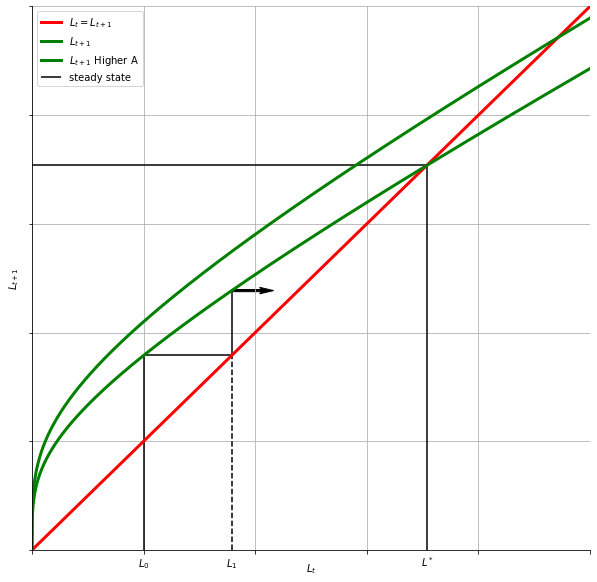

In [556]:
# The data for labor law of motion
L_t_array = np.linspace(0,10,num=10000)
L_t1_array = lom2_func(L_t_array,eta_val,A_val,X_val,alpha_val,mu_val)
L_t1_array2 = lom2_func(L_t_array,eta_val,4,X_val,alpha_val,mu_val)
line45 = L_t_array

# The figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

# removing axis ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(xmin=0,xmax=10)
ax.set_ylim(ymin=0,ymax=10)

# plotting the law of motion for labor 
ax.plot(L_t_array, line45, label="$L_t = L_{t+1}$", color='red',linewidth=3)
ax.plot(L_t_array, L_t1_array, label="$L_{t+1}$", color='green',linewidth=3)
ax.plot(L_t_array, L_t1_array2, label="$L_{t+1}$ Higher A", color='green',linewidth=3)

# plotting steady state
ax.vlines(ss_val, ymin = 0, ymax=ss_val, label='steady state', color="black")
ax.hlines(ss_val, xmin = 0, xmax=ss_val, color="black")
plt.text(ss_val-0.1, -0.3, '$L^*$')

# plotting transition to steady state
L_0 = lom2_func(2,eta_val,A_val,X_val,alpha_val,mu_val)
L_1 = lom2_func(L_0,eta_val,A_val,X_val,alpha_val,mu_val)

ax.vlines(2, 0, L_0, color="black")
plt.text(2-0.1, -0.3, '$L_0$')
ax.hlines(L_0, 2, L_0, color="black")
ax.vlines(L_0, L_0, L_1, color="black")
ax.vlines(L_0, 0, L_0, linestyle='dashed', color="black")
plt.text(L_0-0.1, -0.3, '$L_1$')
ax.arrow(L_0, L_1, 0.5, 0, width=0.04, head_length=0.25, overhang=0.15, color="black")

ax.set_xlabel("$L_t$")
ax.set_ylabel("$L_{t+1}$")
ax.legend(loc="upper left")

ax.grid()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

> **Note:** If you are not that friendly with markdown and latex you can refer to an external document with the model description instead.

We consider the **standard Solow-model** where:

1. $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $A_t$ is technology (growing with a constant rate of $g$)
* $Y_t = F(K_t,A_tL_t)$ is GDP

**Saving** is a constant fraction of GDP

$$ S_t = sY_t,\,s\in(0,1) $$

such that **capital accumulates** according to

$$ K_{t+1}=S_{t}+(1-\delta)K_{t}=sF(K_{t},A_{t}L_{t})+(1-\delta)K_{t}, \delta \in (0,1) $$

The **production function** has **constant-return to scale** such that

$$ \frac{Y_{t}}{A_{t}L_{t}}=\frac{F(K_{t},A_{t}L_{t})}{A_{t}L_{t}}=F(\tilde{k}_{t},1)\equiv f(\tilde{k}_{t}) $$

where $\tilde{k}_t = \frac{K_t}{A_{t}L_{t}}$ is the technology adjusted capital-labor ratio.

The **transition equation** then becomes

$$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}_{t})+(1-\delta)\tilde{k}_{t}] $$

We assume the **production function** is **Cobb-Douglas** so

$$ F(K_{t},A_{t}L_{t})=K_{t}^{\alpha}(A_{t}L_{t})^{1-\alpha}\Rightarrow f(\tilde{k}_{t})=\tilde{k}_{t}^{\alpha} $$

# Steady state

## Analytical solution

We can use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] $$

First we define all **symbols**:

In [8]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

Then we define the **steady state equation**

In [9]:
ss = sm.Eq(k,(s*k**alpha+(1-delta)*k)/((1+n)*(1+g)))

and **solve** it

In [4]:
kss = sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

For later use, we turn the solution into a **Python funciton**

In [5]:
ss_func = sm.lambdify((s,g,n,alpha,delta),kss)

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [6]:
s = 0.2
g = 0.02
n = 0.01
alpha = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [7]:
solution = modelproject.solve_for_ss(s,g,n,alpha,delta)

print(f'analytical solution is: {ss_func(s,g,n,alpha,delta):.3f}')
print(f' numerical solution is: {solution.root:.3f}')

analytical solution is: 1.904
 numerical solution is: 1.904


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.